In [180]:
%matplotlib inline

In [181]:
# Import Dependencies
import json
import requests
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np
import scipy.stats as st
from scipy.stats import linregress


In [182]:
# Import csv file and make DataFrame
uber_data = Path("../Resources/Uber_Project_CSV.csv")
uber_df = pd.read_csv(uber_data)
uber_df.head()

,pickup_dt,borough,pickups,spd,vsb,temp,dewp,slp,pcp01,pcp06,pcp24,sd,hday
0,1/1/2015 1:00,Bronx,152,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0,Y
1,1/1/2015 1:00,Brooklyn,1519,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0,Y
2,1/1/2015 1:00,EWR,0,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0,Y
3,1/1/2015 1:00,Manhattan,5258,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0,Y
4,1/1/2015 1:00,Queens,405,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0,Y


In [183]:
#Import URL and API CSV file
url = "https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/new%2520york%2520city/2015-01-01/2015-06-30?elements=datetime%2CdatetimeEpoch%2Ctemp%2Ctempmax%2Ctempmin%2Cprecip%2Cwindspeed%2Cwindgust%2Cfeelslike%2Cfeelslikemax%2Cfeelslikemin%2Cpressure%2Cstations%2Cdegreedays%2Caccdegreedays&include=fcst%2Cobs%2Chistfcst%2Cstats%2Chours&key=9R8U63UTPUJVYD92WRCVMZZXB&options=preview&contentType=json"
weather_api = Path("../Resources/NYC_Weather_API_data.csv")
weather_df= pd.read_csv(weather_api)
weather_df.head()


,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,new york city,1/1/2015,38.7,27.3,32.8,35.8,17.1,25.6,9.6,37.7,...,9.9,5,NaN,2015-01-01T07:20:09,2015-01-01T16:39:07,0.38,Clear,Clear conditions throughout the day.,clear-day,"72505394728,KLGA,KNYC,72503014732"
1,new york city,1/2/2015,42.2,36.0,38.6,36.5,28.1,32.2,16.8,41.0,...,9.5,5,NaN,2015-01-02T07:20:15,2015-01-02T16:39:58,0.41,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"72505394728,KLGA,KNYC,72503014732"
2,new york city,1/3/2015,40.7,33.5,35.8,35.0,25.9,30.2,26.1,69.4,...,5.2,3,NaN,2015-01-03T07:20:19,2015-01-03T16:40:50,0.45,"Snow, Rain, Partially cloudy",Partly cloudy throughout the day with rain or ...,rain,"72505394728,KLGA,KNYC,72503014732"
3,new york city,1/4/2015,55.4,41.0,48.2,55.4,36.6,46.6,44.6,87.4,...,3.8,3,NaN,2015-01-04T07:20:20,2015-01-04T16:41:44,0.50,"Rain, Overcast",Cloudy skies throughout the day with rain.,rain,"72505394728,KLGA,KNYC,72503014732"
4,new york city,1/5/2015,50.3,21.8,36.3,50.3,11.4,27.8,12.2,37.1,...,9.9,5,NaN,2015-01-05T07:20:19,2015-01-05T16:42:40,0.52,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"72505394728,KLGA,KNYC,72503014732"


In [184]:
#Isolate short rain pickups
rain_data_df = uber_df[["pickup_dt","borough", "pickups", "pcp01", "pcp06", "pcp24"]]
short_rain_df = rain_data_df[(rain_data_df["pcp01"] > 0) & (rain_data_df["pcp06"] == 0) & (rain_data_df["pcp24"] == 0)]
short_rain_chart_df =short_rain_df[["pickup_dt", "borough", "pickups"]]
short_rain_chart_df = short_rain_chart_df.groupby("borough").agg({"pickups":"sum"}).reindex()
short_rain_chart_df

,pickups
borough,
Bronx,8584
Brooklyn,94105
EWR,1
Manhattan,447622
Queens,53488
Staten Island,275


In [185]:
#Find total and average pickups for short rain
short_rain_df = short_rain_df.astype({"pickup_dt":"datetime64[D]"})
avg_short_rain = short_rain_df.groupby("pickup_dt").agg({"pickups": "sum"}).reindex()
days_of_short_rain = avg_short_rain.count()
total_short_rain = sum(avg_short_rain["pickups"])
avg_short_rain_total = total_short_rain/days_of_short_rain
avg_short_rain_total = int(avg_short_rain_total.round(2))
avg_short_rain_total

15495

In [186]:
#Isolate medium rain pickups
medium_rain_df = rain_data_df[(rain_data_df["pcp06"] > 0) & (rain_data_df["pcp01"] == 0) & (rain_data_df["pcp24"] == 0)]
medium_rain_chart_df = medium_rain_df[["borough", "pickups"]]
medium_rain_chart_df = medium_rain_chart_df.groupby("borough").agg({"pickups":"sum"}).reindex()
medium_rain_chart_df

,pickups
borough,
Bronx,21022
Brooklyn,234293
EWR,5
Manhattan,917997
Queens,130854
Staten Island,681


In [187]:
#Find total and average pickups for medium rain
medium_rain_df = medium_rain_df.astype({"pickup_dt":"datetime64[D]"})
avg_medium_rain = medium_rain_df.groupby("pickup_dt").agg({"pickups": "sum"}).reindex()
days_of_medium_rain = avg_medium_rain.count()
total_medium_rain = sum(avg_medium_rain["pickups"])
avg_medium_rain_total = total_medium_rain/days_of_medium_rain
avg_medium_rain_total = int(avg_medium_rain_total.round(2))
avg_medium_rain_total

20397

In [188]:
#ISolate heavy rain pickups
heavy_rain_df = rain_data_df[(rain_data_df["pcp24"] > 0) & (rain_data_df["pcp01"] == 0) & (rain_data_df["pcp06"] == 0)]
heavy_rain_chart_df = heavy_rain_df[["borough", "pickups","pcp24"]]
heavy_rain_chart_df = heavy_rain_chart_df.groupby("borough").agg({"pickups":"sum"}).reindex()
heavy_rain_chart_df

,pickups
borough,
Bronx,50038
Brooklyn,514271
EWR,31
Manhattan,2433263
Queens,318784
Staten Island,1513


In [189]:
#Find total pickups and average pickups for heavy rain
heavy_rain_df = heavy_rain_df.astype({"pickup_dt":"datetime64[D]"})
avg_heavy_rain = heavy_rain_df.groupby("pickup_dt").agg({"pickups": "sum"}).reindex()
days_of_heavy_rain = avg_heavy_rain.count()
total_heavy_rain = sum(avg_heavy_rain["pickups"])
avg_heavy_rain_total = total_heavy_rain/days_of_heavy_rain
avg_heavy_rain_total = int(avg_heavy_rain_total.round(0))
avg_heavy_rain_total

29638

In [190]:
#Isolate snow pickups
snow_data_df = uber_df[["pickup_dt", "borough", "pickups", "sd"]]
snow_df = snow_data_df[(snow_data_df["sd"] > 0)]
snow_chart_df = snow_df[["borough", "pickups",]]
snow_chart_df = snow_chart_df.groupby("borough").agg({"pickups":"sum"}).reindex()
snow_chart_df


,pickups
borough,
Bronx,53225
Brooklyn,623687
EWR,27
Manhattan,3149007
Queens,351742
Staten Island,1643


In [191]:
# Find the total and average snow pickups
snow_df = snow_df.astype({"pickup_dt":"datetime64[D]"})
avg_snow = snow_df.groupby("pickup_dt").agg({"pickups": "sum"}).reindex()
days_of_snow = avg_snow.count()
total_snow = sum(avg_snow["pickups"])
avg_snow_total = total_snow/days_of_snow
avg_snow_total = int(avg_snow_total.round(0))
avg_snow_total

70864

In [192]:
#Isolate pickups for no precipitation
no_precipitation_data_df = uber_df[(uber_df["pcp01"] == 0) & (uber_df["pcp06"] == 0) & (uber_df["pcp24"] == 0) & (uber_df["sd"] == 0)]
no_precipitation_chart_df = no_precipitation_data_df[["borough", "pickups"]]
no_precipitation_chart_df = no_precipitation_chart_df.groupby("borough").agg({"pickups":"sum"}).reindex()
no_precipitation_chart_df

,pickups
borough,
Bronx,92588
Brooklyn,925314
EWR,39
Manhattan,3907896
Queens,530198
Staten Island,2971


In [193]:
#Find the total and average pickups with no precipitation
no_precipitation_data_df= no_precipitation_data_df.astype({"pickup_dt":"datetime64[D]"})
avg_no_precipitation = no_precipitation_data_df.groupby("pickup_dt").agg({"pickups": "sum"}).reindex()
days_of_no_precipitation = avg_no_precipitation.count()
total_no_precipitation = sum(avg_no_precipitation["pickups"])
avg_no_precipitation_total = total_no_precipitation/days_of_no_precipitation
avg_no_precipitation_total = int(avg_no_precipitation_total.round(2))
avg_no_precipitation_total

47081

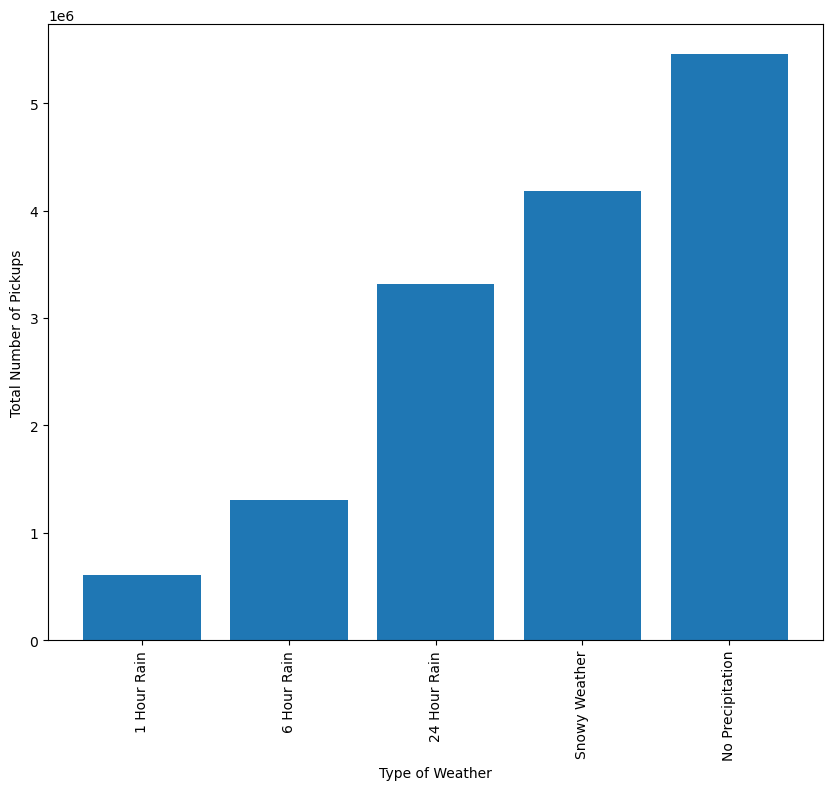

In [194]:
#Create a data frame and bar chart that shows total pickups by different weather type
total_weather = {"Type of Weather": ["1 Hour Rain", "6 Hour Rain", "24 Hour Rain", "Snowy Weather", "No Precipitation"],
                  "Total Pickups": [total_short_rain, total_medium_rain, total_heavy_rain, total_snow, total_no_precipitation]
                  }


total_weather_df = pd.DataFrame(total_weather)

x_axis = np.arange(len(total_weather_df))
tick_locations = [value for value in x_axis]

plt.figure(figsize=(10,8))
plt.bar(x_axis, total_weather_df["Total Pickups"], align="center")
plt.xticks(tick_locations, total_weather_df["Type of Weather"], rotation="vertical")
plt.xlabel("Type of Weather")
plt.ylabel("Total Number of Pickups")
plt.savefig("../Resources/Total_Pickup_weather.png")
plt.show()



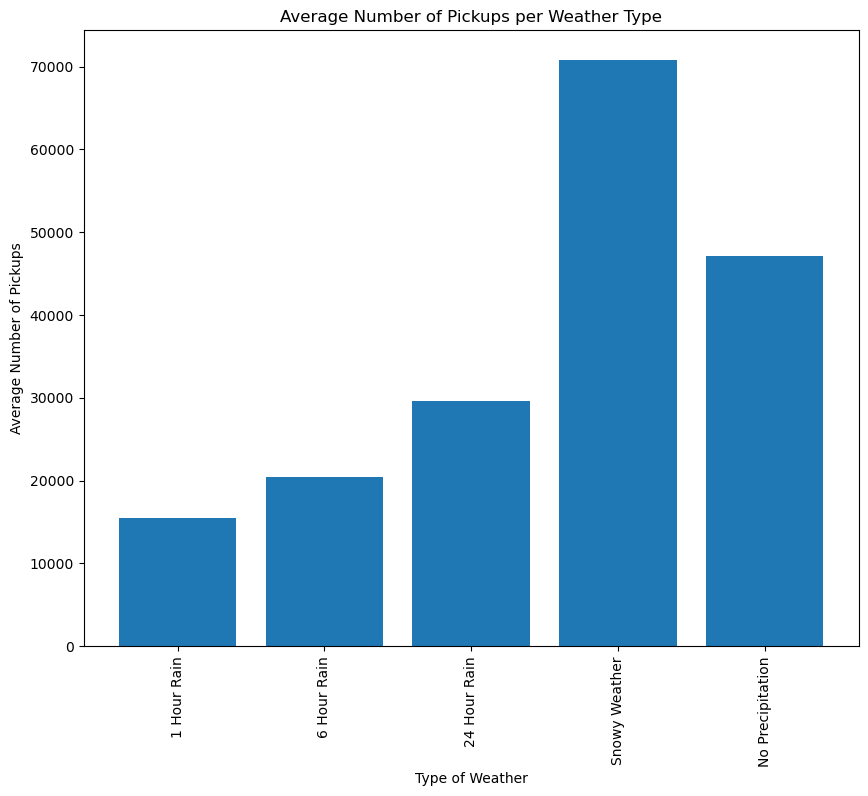

In [195]:
#create a dataframe and bar chart that shows average pickups by different weather type
avg_total_weather = {"Type of Weather": ["1 Hour Rain", "6 Hour Rain", "24 Hour Rain", "Snowy Weather", "No Precipitation"],
                     "Average Pickups": [avg_short_rain_total, avg_medium_rain_total, avg_heavy_rain_total, avg_snow_total, avg_no_precipitation_total]

}
avg_weather_df = pd.DataFrame(avg_total_weather)

x_axis = np.arange(len(avg_weather_df))
tick_locations = [value for value in x_axis]

plt.figure(figsize=(10, 8))
plt.bar(x_axis, avg_weather_df["Average Pickups"], align="center")
plt.xticks(tick_locations, avg_weather_df["Type of Weather"], rotation ="vertical")
plt.xlabel("Type of Weather")
plt.ylabel("Average Number of Pickups")
plt.title("Average Number of Pickups per Weather Type")
plt.savefig("../Resources/avg_Pickup_weather.png")
plt.show()


In [196]:
# Does Wind Speed affect the number of pickups? How does wind with or without precipitation affect it? - Ryan
uber_df=uber_df.astype({"pickup_dt":"datetime64[D]"})

# Does Wind Speed affect the number of pickups? How does wind with or without precipitation affect it? - Ryan
wind_df= uber_df[["pickup_dt", "borough", "pickups", "spd", "pcp01"]]
wind_df= wind_df.rename(columns={"pickup_dt": "Date of Observation"}|{"borough":"Borough"}|{"pickups":"Number of Pickups"}|{"spd":"Wind Speed"}|{"pcp01":"Precipitaion Amount"})

wind_df.head()


,Date of Observation,Borough,Number of Pickups,Wind Speed,Precipitaion Amount
0,2015-01-01,Bronx,152,5.0,0.0
1,2015-01-01,Brooklyn,1519,5.0,0.0
2,2015-01-01,EWR,0,5.0,0.0
3,2015-01-01,Manhattan,5258,5.0,0.0
4,2015-01-01,Queens,405,5.0,0.0


In [197]:
#toatl number of pickups and average wind speed per date

converted_wind_df= wind_df[["Borough", "Number of Pickups", "Wind Speed", "Precipitaion Amount", "Date of Observation"]]
converted_wind_df= converted_wind_df.groupby("Date of Observation").agg({"Number of Pickups": "sum", "Wind Speed": "mean"}).reindex()
converted_wind_df.head()

,Number of Pickups,Wind Speed
Date of Observation,,
2015-01-01,54671,6.065359
2015-01-02,39668,7.582278
2015-01-03,59244,6.243438
2015-01-04,43230,5.645541
2015-01-05,43591,10.898089


The r-value is: -0.22577964333481676


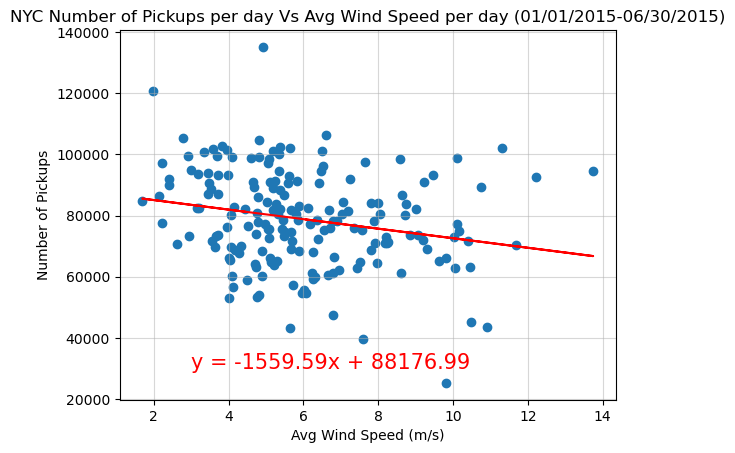

In [198]:
#plt.scatter(converted_wind_df["Wind Speed"], converted_wind_df["Number of Pickups"], edgecolors= "black", marker="o")
x_values= converted_wind_df["Wind Speed"]
y_values= converted_wind_df["Number of Pickups"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values,y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Incorporate the other graph properties
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(3,30000),fontsize=15,color="red")
plt.title("NYC Number of Pickups per day Vs Avg Wind Speed per day (01/01/2015-06/30/2015)")
plt.ylabel("Number of Pickups")
plt.xlabel("Avg Wind Speed (m/s)")
plt.grid(True, alpha= 0.5)
print(f"The r-value is: {rvalue}")


# Save the figure
plt.savefig("../Resources/Pickup_wind.png")

# Show plot
plt.show()

In [199]:
#Create DF from uber data showing total number of pickups per day

pickup_df= uber_df[["pickup_dt", "pickups"]]
pickup_df=pickup_df.rename(columns={"pickup_dt": "Date of Observation"}|{"pickups":"Number of Pickups"})
pickup_df=pickup_df.groupby("Date of Observation").agg({"Number of Pickups": "sum"}).reindex()
pickup_df.head()

,Number of Pickups
Date of Observation,
2015-01-01,54671
2015-01-02,39668
2015-01-03,59244
2015-01-04,43230
2015-01-05,43591


In [200]:
#Create DF from API for datetime and feels like temp

weather_df=weather_df[["datetime", "feelslike"]]
weather_df=weather_df.rename(columns={"datetime": "Date of Observation"}|{"feelslike":"Feels Like Temperature(C)"})
weather_df=weather_df.astype({"Date of Observation":"datetime64[D]"})
weather_df.head()

,Date of Observation,Feels Like Temperature(C)
0,2015-01-01,25.6
1,2015-01-02,32.2
2,2015-01-03,30.2
3,2015-01-04,46.6
4,2015-01-05,27.8


In [201]:
#Merging weather_df from API and pickup_df from our Dataset to see the number of rides per day vs the feels like temp
nyc_merge_df= pd.merge(pickup_df, weather_df, on='Date of Observation', how='inner')
nyc_merge_df.head()

,Date of Observation,Number of Pickups,Feels Like Temperature(C)
0,2015-01-01,54671,25.6
1,2015-01-02,39668,32.2
2,2015-01-03,59244,30.2
3,2015-01-04,43230,46.6
4,2015-01-05,43591,27.8


The r-value is: 0.3642127572146948


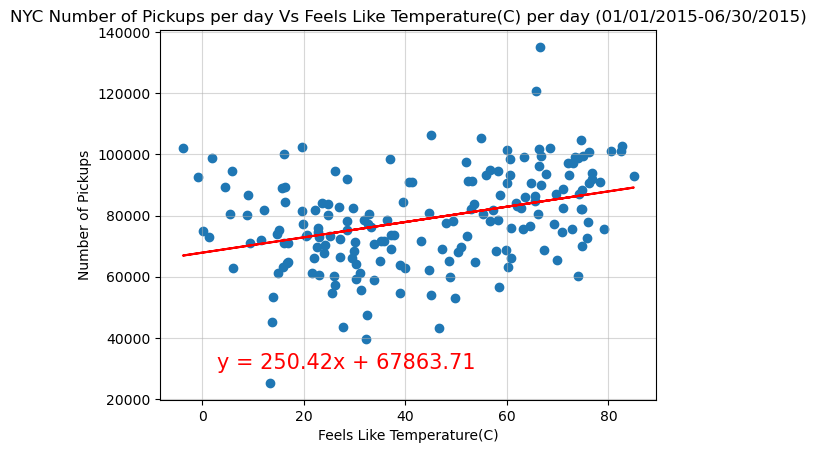

In [202]:
#Create plot showing relationship between number of pickups and feels like temp
x_values= nyc_merge_df["Feels Like Temperature(C)"]
y_values= nyc_merge_df["Number of Pickups"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values,y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Incorporate the other graph properties
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(3,30000),fontsize=15,color="red")
plt.title("NYC Number of Pickups per day Vs Feels Like Temperature(C) per day (01/01/2015-06/30/2015)")
plt.ylabel("Number of Pickups")
plt.xlabel("Feels Like Temperature(C)")
plt.grid(True, alpha= 0.5)
print(f"The r-value is: {rvalue}")


# Save the figure
plt.savefig("../Resources/Pickup_feelslike.png")

# Show plot
plt.show()

In [203]:
#Does different boroughs? Ryan
#How do the different borughs compare with pickups?
borough_df= uber_df[["borough", "pickups"]]
borough_df= borough_df.rename(columns={"borough": "NYC Borough"}|{"pickups":"Number of Pickups"})
borough_df= borough_df.groupby("NYC Borough").agg({"Number of Pickups": "sum"}).reindex()
borough_df.head

<bound method NDFrame.head of                Number of Pickups
NYC Borough                     
Bronx                     220047
Brooklyn                 2321035
EWR                          105
Manhattan               10367841
Queens                   1343528
Staten Island               6957>

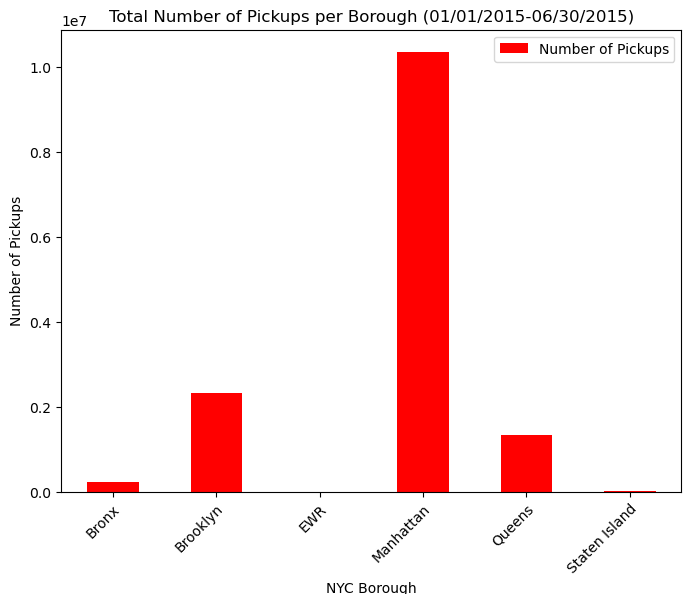

In [204]:
#Plot to show the total pickups in each Borough
figure1 = borough_df.plot(kind="bar", facecolor="red", figsize=(8,6),
                                title="Total Number of Pickups per Borough (01/01/2015-06/30/2015)",
                                xlabel="NYC Borough",
                                ylabel="Number of Pickups")

# Configure x-tick rotation
xticklabels = borough_df.index
figure1.set_xticklabels(xticklabels, rotation=45, rotation_mode="anchor", ha="right", wrap=True)
plt.savefig("../Resources/Pickup_borough.png")

plt.show()

In [205]:
#How does the real feel temperature effect the totoal number of pickups?

#Create DF from uber data showing total number of pickups per day

pickup_df= uber_df[["pickup_dt", "pickups"]]
pickup_df=pickup_df.rename(columns={"pickup_dt": "Date of Observation"}|{"pickups":"Number of Pickups"})
pickup_df=pickup_df.groupby("Date of Observation").agg({"Number of Pickups": "sum"}).reindex()
pickup_df.head()

,Number of Pickups
Date of Observation,
2015-01-01,54671
2015-01-02,39668
2015-01-03,59244
2015-01-04,43230
2015-01-05,43591


In [206]:
# Does the day of the week affect pickups? - Fidel
uber_df['timestamp']= pd.to_datetime(uber_df['pickup_dt'])
uber_df['timestamp'].dt.day_name()
uber_df['day_of_the_week']=uber_df['timestamp'].dt.day_name()
uber_df_2=uber_df[["day_of_the_week", "pickups"]]


print(uber_df_2)


      day_of_the_week  pickups
0            Thursday      152
1            Thursday     1519
2            Thursday        0
3            Thursday     5258
4            Thursday      405
...               ...      ...
29096         Tuesday        0
29097         Tuesday     3828
29098         Tuesday      580
29099         Tuesday        0
29100         Tuesday        3

[29101 rows x 2 columns]


In [207]:
# Extract individual days
group0 = uber_df_2[uber_df_2["day_of_the_week"] == 'Friday']["pickups"]
group1 = uber_df_2[uber_df_2["day_of_the_week"] == 'Monday']["pickups"]
group2 = uber_df_2[uber_df_2["day_of_the_week"] == 'Saturday']["pickups"]
group3 = uber_df_2[uber_df_2["day_of_the_week"] == 'Sunday']["pickups"]
group4 = uber_df_2[uber_df_2["day_of_the_week"] == 'Thursday']["pickups"]
group5= uber_df_2[uber_df_2["day_of_the_week"] == 'Tuesday']["pickups"]
group6= uber_df_2[uber_df_2["day_of_the_week"] == 'Wednesday']["pickups"]

In [208]:
# Perform the ANOVA
st.f_oneway(group0, group1, group2, group3, group4,group5,group6)

F_onewayResult(statistic=12.766621162505526, pvalue=1.880511996714594e-14)

In [209]:
#create a new data frame to show total pickups_per_day
pick_up_totals=uber_df.groupby("day_of_the_week")["pickups"].sum()
pick_up_totals

day_of_the_week
Friday       2261480
Monday       1698122
Saturday     2410063
Sunday       2004315
Thursday     2140072
Tuesday      1864578
Wednesday    1887143
Name: pickups, dtype: int64

In [210]:
# Labels for the sections of our pie chart
labels = ["Friday", "Monday", "Saturday", "Sunday", "Thursday","Tuesday","Wednesday"]

# The values of each section of the pie chart
sizes = [2261480, 1698122,2410063, 2004315,2140072,1864578,1887143]

# The colors of each section of the pie chart
colors = ["red", "orange", "purple", "blue", "yellow","green", "pink"]

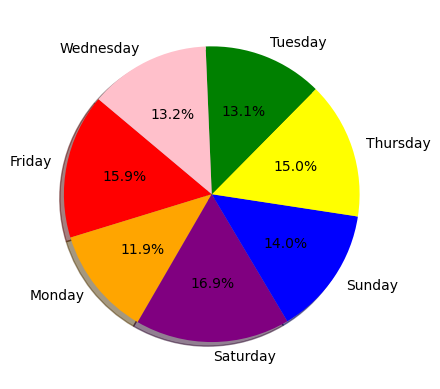

In [211]:
# Creates the pie chart based upon the values above
# Automatically finds the percentages of each part of the pie chart
plt.pie(sizes, labels=labels, colors=colors,
        autopct="%1.1f%%", shadow=True, startangle=140)
plt.savefig("../Resources/Pickup_per_day.png")
plt.show()

In [212]:
#creating variables for the barchart
pickup_by_day=uber_df.groupby(["day_of_the_week"])["pickups"].mean()
pick_by_days= pickup_by_day.sort_values(ascending= True)

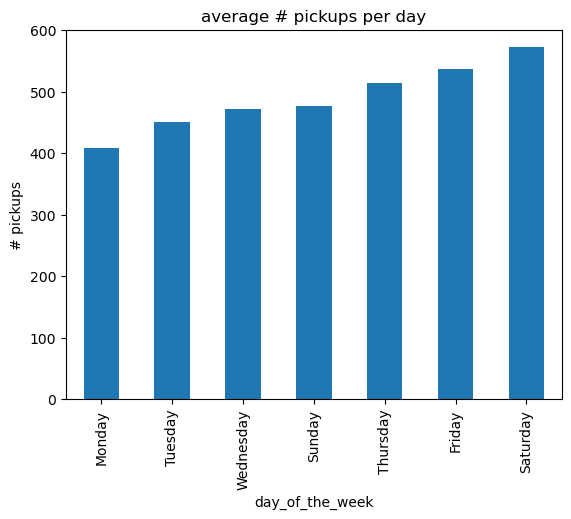

<Figure size 640x480 with 0 Axes>

In [213]:
#Bar graph to show the average pickups occured per day
pick_up_days_chart= pick_by_days.plot(kind= 'bar', fig= (7,7))
# Set the xlabel and ylabel using class methods
pick_up_days_chart.set_xlabel("day_of_the_week")
pick_up_days_chart.set_ylabel("# pickups")

#add title to chart
plt.title('average # pickups per day')
plt.savefig("../Resources/Pickup_perday_bar.png")

plt.show()
plt.tight_layout()

In [214]:
#Difference in Weekdays vs Weekends? - Fidel
uber_df['timestamp']= pd.to_datetime(uber_df['pickup_dt'])
uber_df['timestamp'].dt.dayofweek
uber_df['weekday'] = uber_df['timestamp'].dt.day_of_week
uber_df['day_type'] = uber_df['weekday'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')
trip_by_week= uber_df[["day_type", "pickups"]]
print(trip_by_week)


      day_type  pickups
0      Weekday      152
1      Weekday     1519
2      Weekday        0
3      Weekday     5258
4      Weekday      405
...        ...      ...
29096  Weekday        0
29097  Weekday     3828
29098  Weekday      580
29099  Weekday        0
29100  Weekday        3

[29101 rows x 2 columns]


In [215]:
# Extract weekdays and weekends
group0 = trip_by_week[trip_by_week["day_type"] == 'Weekday']["pickups"]
group1 = trip_by_week[trip_by_week["day_type"] == 'Weekend']["pickups"]

In [216]:
# Perform the ANOVA
st.f_oneway(group0, group1)

F_onewayResult(statistic=14.014507957897177, pvalue=0.00018175457982768056)

In [217]:
#creating variables for the barchart
pickup_week=trip_by_week.groupby(["day_type"])["pickups"].mean()
pick_by_week= pickup_week.sort_values(ascending= True)

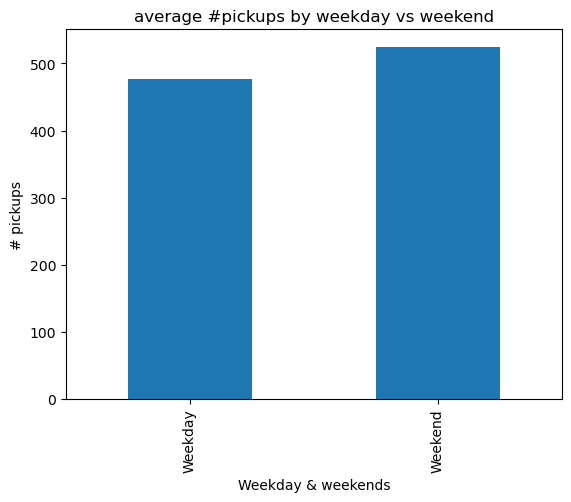

<Figure size 640x480 with 0 Axes>

In [218]:
#Bar graph to show the average pickups occured per day
pick_up_week_chart= pick_by_week.plot(kind= 'bar', fig= (7,7))
# Set the xlabel and ylabel using class methods
pick_up_week_chart.set_xlabel("Weekday & weekends")
pick_up_week_chart.set_ylabel("# pickups")

#add title to chart
plt.title('average #pickups by weekday vs weekend')
plt.savefig("../Resources/Pickup_weekday_weekend.png")

plt.show()
plt.tight_layout()

In [219]:
#variables for Pie chart
by_week= trip_by_week.groupby("day_type")["pickups"].sum()
print(by_week)

day_type
Weekday    9851395
Weekend    4414378
Name: pickups, dtype: int64


In [220]:
# Labels for the sections of our pie chart
labels = ["Weekday", "Weekend"]

# The values of each section of the pie chart
sizes = [9851395, 4414378,]

# The colors of each section of the pie chart
colors = [ "purple", "yellow"]

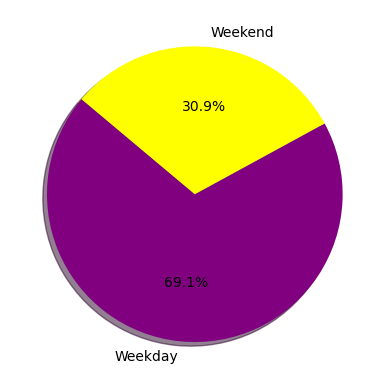

In [221]:
# Creates the pie chart based upon the values above
# Automatically finds the percentages of each part of the pie chart
plt.pie(sizes, labels=labels, colors=colors,
        autopct="%1.1f%%", shadow=True, startangle=140)
plt.savefig("../Resources/Pickup_weekend_pie.png")
plt.show()

In [222]:
# does Holiday's affcet the number of pickups?
#creating holiday dataframe
holiday_df= uber_df[["pickup_dt","pickups","hday"]]
by_holiday= holiday_df.groupby("hday")["pickups"].mean()


print(by_holiday)

hday
N    492.339957
Y    437.199822
Name: pickups, dtype: float64


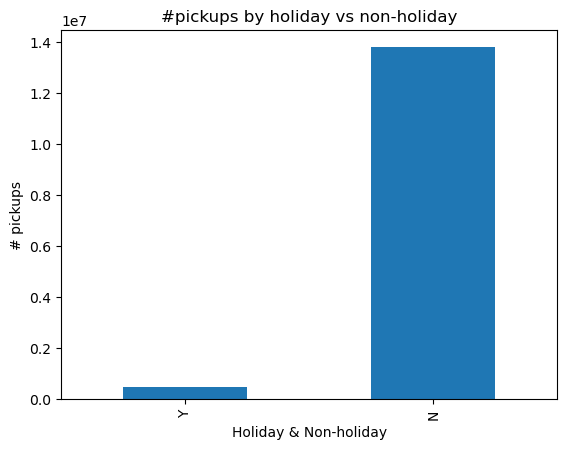

<Figure size 640x480 with 0 Axes>

In [223]:
#bar graph creation
pick_by_holiday= by_holiday.sort_values(ascending= True)
#Bar graph to show the average pickups occured per day
pick_up_holiday_chart= pick_by_holiday.plot(kind= 'bar', fig= (7,7))
# Set the xlabel and ylabel using class methods
pick_up_holiday_chart.set_xlabel("Holiday & Non-holiday")
pick_up_holiday_chart.set_ylabel("# pickups")

#add title to chart
plt.title("#pickups by holiday vs non-holiday")
plt.savefig("../Resources/Pickup_holiday_bar.png")

plt.show()
plt.tight_layout()

In [224]:
# Labels for the sections of our pie chart
labels = ["Holiday", "Non-holiday"]

# The values of each section of the pie chart
sizes = [490101, 13775672]

# The colors of each section of the pie chart
colors = [ "green", "pink"]

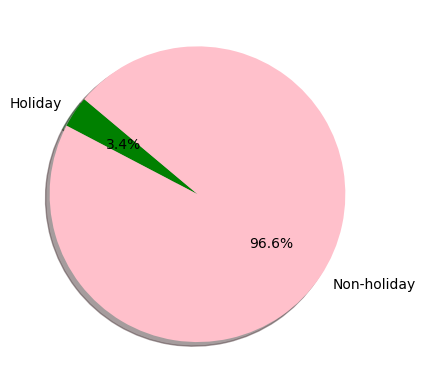

In [225]:
# Creates the pie chart based upon the values above
# Automatically finds the percentages of each part of the pie chart
plt.pie(sizes, labels=labels, colors=colors,
        autopct="%1.1f%%", shadow=True, startangle=140)
plt.savefig("../Resources/Pickup_holidy_pie.png")
plt.show()